# Data Preprocessing
This notebook utilizes the preprocessed data (in the previous notebook) to build different models using limited data. These models are compared against each other. 

In [1]:
# Imports
import tensorflow as tf
from tensorflow import keras
import numpy as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

## Utility 
import os 
import json
from datetime import datetime

In [2]:
# Set-up 
spread_over_time_path = "./datasets/spread_over_time/spread_over_time_standardized.json"
spread_over_country_path = "./datasets/spread_over_country/spread_over_country_standardized.json"

In [3]:
# JSON read 
with open(spread_over_time_path, "r") as fp:
    data = fp.read()
    spread_over_time_dict = json.loads(data)
    
with open(spread_over_country_path, "r") as fp:
    data = fp.read()
    spread_over_country_dict = json.loads(data)

In [4]:
# Take training sets and shuffle
train_set_time = spread_over_time_dict["train"]
train_set_country = spread_over_country_dict["train"]

In [5]:
# Shuffle 
from sklearn.utils import shuffle
train_set_time = np.array(shuffle(train_set_time))
train_set_country = np.array(shuffle(train_set_country))

<ipython-input-5-9e44ac78ea89>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  train_set_country = np.array(shuffle(train_set_country))


In [6]:
# Val and train sets 
train_set_time_val = spread_over_time_dict["val"]
train_set_country_val = spread_over_country_dict["val"]
train_set_time_test = spread_over_time_dict["test"]
train_set_country_test = spread_over_country_dict["test"]

In [7]:
# Shuffle 
train_set_time_val = np.array(shuffle(train_set_time_val))
train_set_country_val = np.array(shuffle(train_set_country_val))
train_set_time_test = np.array(shuffle(train_set_time_test))
train_set_country_test = np.array(shuffle(train_set_country_test))

<ipython-input-7-e95c15006522>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  train_set_country_val = np.array(shuffle(train_set_country_val))
<ipython-input-7-e95c15006522>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  train_set_country_test = np.array(shuffle(train_set_country_test))


In [8]:
#train_set_time = train_set_time.T
#train_set_time_val = train_set_time_val.T
#train_set_time_test = train_set_time_test.T

In [9]:
# Shapes 
train_set_time.shape, train_set_time_val.shape, train_set_time_test.shape

((90, 42), (90, 12), (90, 6))

### Split into X and Y datasets

### Expanding the dimensions of the datasets
* This must be done as the RNNs (LSTMs and GRU ) expect [batch_size, timeseries, input_dims] format
* Also increase the data available with 

In [10]:
# Datasets 
# Train 
#X_train = np.expand_dims(X_train, axis=2)
#y_train = np.expand_dims(y_train, axis=2)
# Val
#X_val = np.expand_dims(X_val, axis=2)
#y_val = np.expand_dims(y_val, axis=2)
# Test
#X_test = np.expand_dims(X_test, axis=2)
#y_test = np.expand_dims(y_test, axis=2)

In [11]:
# Functions for array windowing
def create_windowed_arrays(array, window_length=9):
    zipped_array = zip(*[array[i:] for i in range(window_length)])
    return np.array(list(zipped_array))

In [12]:
# Create window truncated X and y 
def create_x_y_truncated(dataset, window_length=9):
    truncated_dataset = np.array([create_windowed_arrays(array,window_length) for array in dataset])
    truncated_dataset = truncated_dataset.reshape(-1, window_length, 1)
    return truncated_dataset[:, :-1], truncated_dataset[:, -1:]

In [13]:
# Shuffle X and y
def shuffle_x_y(X, y):
    indices = np.arange(len(X))
    shuffle_indices = np.random.permutation(indices)
    return X[shuffle_indices], y[shuffle_indices]

In [29]:
# Window length 
window_length = 9
X_train, y_train = create_x_y_truncated(train_set_time, window_length)
X_val, y_val = create_x_y_truncated(train_set_time_val, window_length)

# Shuffle = 
X_train, y_train = shuffle_x_y(X_train, y_train)
X_val, y_val = shuffle_x_y(X_val, y_val)


In [15]:
train_set_time.shape

(90, 42)

In [16]:
X_train.shape, X_val.shape

((3060, 8, 1), (360, 8, 1))

In [17]:
# Check if X_train values are present in 
train_set_time.shape

(90, 42)

## Trial run 
This run is to verify that there are no processing erros in the previous. 

In [25]:
def x_y_split(window):
    return (window[:-1], window[-1:])

In [26]:
def tensor_window(sequence, window_length=4):
    df = tf.data.Dataset.from_tensor_slices(sequence)
    df = df.window(window_length, shift=1, drop_remainder=True)
    df = df.flat_map(lambda window: window.batch(window_length))
    return df

In [27]:
def get_data_cubes(sequence, size, shift=None, stride=1, drop_remainder=False):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(size=size, shift=shift, stride=stride, drop_remainder=drop_remainder)
    ds = ds.flat_map(lambda x: x.batch(size))
    return ds

In [69]:
# Plot predictions function 
def create_predictions_plot(model, X=X_val, y=y_val, cmap_name="viridis", model_name="None"):
    cmap = mpl.cm.get_cmap(cmap_name)
    # Random Index
    random_index = np.random.randint(len(X))
    sample_series = X[random_index].flatten()
    actual_value = y[random_index].flatten()
    timeseries_labels = np.arange(len(sample_series))
    # Dataset 
    df_plot = pd.DataFrame(np.c_[timeseries_labels, sample_series], columns=["Time", "Series"])
    df_plot.plot(kind="scatter", x="Time", y="Series", color=cmap(0.2), alpha=0.90, s=30 )
    # Prediction
    preds = model.predict(sample_series.reshape(1, -1, 1))
    if(type(preds) == np.ndarray):    
        preds  = preds.flatten()
    #plt.scatter(timeseries_labels, sample_series, colors="plasma")
    plt.scatter(len(sample_series)+1, preds, color="red", alpha=0.9, label="Model Prediction")
    plt.scatter(len(sample_series)+1, actual_value, color=cmap(0.7), label="Actual Value")
    # Title
    plt.title("{0} Model predictions".format(model_name))


In [22]:
import datetime
def log_dir_names():
    folder_name = "./logs/"
    model_name = datetime.datetime.now().strftime("%H-%M-%S")
    return folder_name+model_name

In [23]:
# GRU and LSTM input shape
# [batch_size, timeseries_dim, input_dim]

### Naive Model 
Naive or the Base model assumes that the future gdp values are equal to current ones. 

In [24]:
# Predicting the last value in time series
y_pred = X_val[:, :-1]
naive_error = np.mean(keras.losses.mean_squared_error(y_pred, y_val))
print("Baseline error: "+str(naive_error))

Baseline error: 0.12441831048522355


### Simple Regressions
A simple linear regression that uses adam as optimizer

In [156]:
# Using a simple regression model
model = keras.models.Sequential([
    keras.layers.BatchNormalization( input_shape = [None, 1]),
    keras.layers.SimpleRNN(1),
    keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer="adam")

In [157]:
model.fit(X_train, y_train, 
          validation_data = (X_val, y_val),
         epochs = 20)

Epoch 1/20
96/96 [==============================] - 1s 8ms/step - loss: 2.0981 - val_loss: 6.1704
Epoch 2/20
96/96 [==============================] - 0s 4ms/step - loss: 1.8635 - val_loss: 5.9170
Epoch 3/20
96/96 [==============================] - 0s 3ms/step - loss: 1.7214 - val_loss: 5.6552
Epoch 4/20
96/96 [==============================] - 0s 4ms/step - loss: 1.6242 - val_loss: 5.4269
Epoch 5/20
96/96 [==============================] - 0s 3ms/step - loss: 1.5182 - val_loss: 5.2334
Epoch 6/20
96/96 [==============================] - 0s 3ms/step - loss: 1.4487 - val_loss: 5.0582
Epoch 7/20
96/96 [==============================] - 0s 4ms/step - loss: 1.3802 - val_loss: 4.8685
Epoch 8/20
96/96 [==============================] - 0s 3ms/step - loss: 1.3110 - val_loss: 4.6935
Epoch 9/20
96/96 [==============================] - 0s 4ms/step - loss: 1.2451 - val_loss: 4.5100
Epoch 10/20
96/96 [==============================] - 0s 4ms/step - loss: 1.0980 - val_loss: 4.2788
Epoch 11/20
96/96 [

In [158]:
# Testing on validation set 
y_preds = model.predict(X_val)
simple_regression_error = np.mean(keras.losses.mean_squared_error(y_preds, y_val))
print("Simple Regression error: "+str(simple_regression_error))

Simple Regression error: 4.727317022250524


### RNN
Recurrent Neural Network that can has hidden states to predict a value in the future. 

In [161]:
train_set_time_val[:, :-1].shape

(90, 11)

In [176]:
gru_units = 64
model = keras.models.Sequential([
    keras.layers.GRU(gru_units, return_sequences = True, input_shape=[None, 1]),
    keras.layers.GRU(gru_units, return_sequences = True), 
    keras.layers.GRU(gru_units),
    keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer="adam")

In [177]:
model.fit(X_train, y_train, 
          validation_data = (X_val, y_val),
         epochs = 40)

Epoch 1/40
96/96 [==============================] - 6s 64ms/step - loss: 0.2060 - val_loss: 0.7405
Epoch 2/40
96/96 [==============================] - 4s 37ms/step - loss: 0.0434 - val_loss: 0.4986
Epoch 3/40
96/96 [==============================] - 4s 36ms/step - loss: 0.0222 - val_loss: 0.3653
Epoch 4/40
96/96 [==============================] - 4s 37ms/step - loss: 0.0127 - val_loss: 0.3033
Epoch 5/40
96/96 [==============================] - 4s 37ms/step - loss: 0.0125 - val_loss: 0.2475
Epoch 6/40
96/96 [==============================] - 4s 37ms/step - loss: 0.0061 - val_loss: 0.2131
Epoch 7/40
96/96 [==============================] - 4s 37ms/step - loss: 0.0104 - val_loss: 0.2025
Epoch 8/40
96/96 [==============================] - 4s 37ms/step - loss: 0.0053 - val_loss: 0.1660
Epoch 9/40
96/96 [==============================] - 4s 38ms/step - loss: 0.0060 - val_loss: 0.1581
Epoch 10/40
96/96 [==============================] - 4s 38ms/step - loss: 0.0031 - val_loss: 0.1358
Epoch 11/

In [182]:
# Testing on validation set 
y_preds = model.predict(X_val)
simple_regression_error = np.mean(keras.losses.mean_squared_error(y_preds, y_val))
print("GRU model error: "+str(model.evaluate(X_val, y_val)))

12/12 [==============================] - ETA: 0s - loss: 0.062 - 0s 24ms/step - loss: 0.0610
GRU model error: 0.06102810800075531


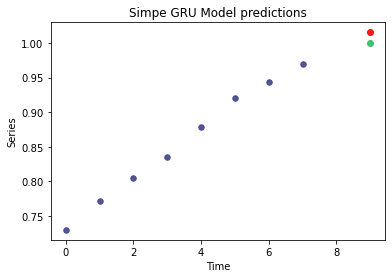

In [183]:
create_predictions_plot(model, X_val, y_val, model_name="Simpe GRU")

## Further Utility
Utility functions that will be used in the next sections

In [25]:
from datetime import datetime

In [30]:
# Function to build, compile and fit
def build_compile_fit(model, epochs=20, optimizer="adam", model_name=None, callbacks=None):
    metrics = ["mean_squared_error", "mean_absolute_error"]
    model.compile(loss="mean_squared_error", 
                 optimizer = optimizer, 
                 metrics=metrics)
    model.fit(X_train, y_train, 
             validation_data=(X_val, y_val), 
             epochs = epochs, 
             callbacks = callbacks)
    return model

# Print the validation error
def print_val_error(model, X = X_val, y = y_val, model_name="None"):
    y_preds = model.predict(X_val)
    model_error = np.mean(keras.losses.mean_squared_error(y_preds.squeeze(), y.squeeze()))
    print("{0} error: {1}".format(model_name, str(model_error)))

In [25]:
models_error = {
    "DecisionTreeRegressor" : 0.13314048355595137,
    "RandomForestRegressor" : 0.14514600484267437,
    "ExtraTreesRegressor" : 0.1377419811742491,
    "SVR" : 1.2977672460380496,
}

In [24]:
log_dir_name = log_dir_names()
early_stopping = keras.callbacks.EarlyStopping(patience=10)
callbacks = [early_stopping, keras.callbacks.TensorBoard(log_dir_name)]

## Truncate the dataset into windows

In [69]:
# Inverting the sets 
# train_set_time = train_set_time.T
# train_set_time_val = train_set_time_val.T
# train_set_time_test = train_set_time_test.T

In [73]:
# Required dims [ batch_size, timeseries, input_dim=1]

### Dropout

In [228]:
dropout_model = 0

In [231]:
# Dropout model
model = keras.models.Sequential([
    keras.layers.GRU(64, input_shape = [None, 1], return_sequences = True, 
                    dropout=0.2, recurrent_dropout = 0.2),
    keras.layers.GRU(64, return_sequences = True, dropout=0.2, recurrent_dropout = 0.2), 
    keras.layers.GRU(64, dropout=0.2, recurrent_dropout = 0.2),
    keras.layers.Dense(1)
])

log_dir_name = log_dir_names()
early_stopping = keras.callbacks.EarlyStopping(patience=10)
callbacks = [early_stopping, keras.callbacks.TensorBoard(log_dir_name)]

build_compile_fit(model, epochs = 20, callbacks=None)

Epoch 1/20
96/96 [==============================] - 36s 378ms/step - loss: 0.2098 - mean_squared_error: 0.2098 - mean_absolute_error: 0.1465 - val_loss: 0.7211 - val_mean_squared_error: 0.7211 - val_mean_absolute_error: 0.2073
Epoch 2/20
96/96 [==============================] - 6s 67ms/step - loss: 0.0847 - mean_squared_error: 0.0847 - mean_absolute_error: 0.0970 - val_loss: 0.4620 - val_mean_squared_error: 0.4620 - val_mean_absolute_error: 0.1451
Epoch 3/20
96/96 [==============================] - 6s 60ms/step - loss: 0.0530 - mean_squared_error: 0.0530 - mean_absolute_error: 0.0891 - val_loss: 0.4044 - val_mean_squared_error: 0.4044 - val_mean_absolute_error: 0.1436
Epoch 4/20
96/96 [==============================] - 6s 63ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - mean_absolute_error: 0.0841 - val_loss: 0.3702 - val_mean_squared_error: 0.3702 - val_mean_absolute_error: 0.1449
Epoch 5/20
96/96 [==============================] - 6s 63ms/step - loss: 0.0720 - mean_squared_err

In [232]:
# Test on validation set 
print_val_error(model, model_name="DropOut Model")

DropOut Model error: 0.21206800513989374


The val loss is a lot higher than train loss. Signs of over-fitting.

### LSTM model
A Long Short-Term Memory model

In [38]:
# Shuffling X_val and y_val
X_val, y_val = shuffle_x_y(X_val, y_val)

In [25]:
# LSTM units 
lstm_units = 64
n_epochs = 20
metrics = ["mean_squared_error", "mean_absolute_error"]
# Call Backs
log_dir_name = log_dir_names()
early_stopping = keras.callbacks.EarlyStopping(patience=10)
callbacks = [early_stopping, keras.callbacks.TensorBoard(log_dir_name)]

model = keras.models.Sequential([
    keras.layers.LSTM(lstm_units,  input_shape = [None, 1], return_sequences = True), 
    keras.layers.LSTM(lstm_units), 
    keras.layers.Dense(1)
    
])

model.compile(loss="mean_squared_error", 
                 optimizer = "adam", 
                 metrics=metrics)

model.fit(X_train, y_train, 
             validation_data=(X_val, y_val), 
             epochs = n_epochs, 
             callbacks = callbacks)

Epoch 1/20
 1/96 [..............................] - ETA: 0s - loss: 2.3600 - mean_squared_error: 2.3600 - mean_absolute_error: 0.6358WARNING:tensorflow:From C:\Users\aadityachaitanya\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
96/96 [==============================] - 5s 54ms/step - loss: 0.2479 - mean_squared_error: 0.2479 - mean_absolute_error: 0.1236 - val_loss: 0.6168 - val_mean_squared_error: 0.6168 - val_mean_absolute_error: 0.1803
Epoch 2/20
96/96 [==============================] - 3s 30ms/step - loss: 0.0416 - mean_squared_error: 0.0416 - mean_absolute_error: 0.0625 - val_loss: 0.4822 - val_mean_squared_error: 0.4822 - val_mean_absolute_error: 0.1420
Epoch 3/20
96/96 [==============================] - ETA: 0s - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.03 - 3

In [26]:
# Test on validation set 
print_val_error(model, model_name="LSTM Model")

LSTM Model error: 0.10471208252064675


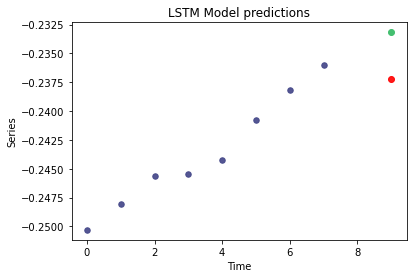

In [27]:
create_predictions_plot(model, model_name="LSTM")

When considering truncated datasets with window length of 9, the standard non-dropout model performs the best. 

### Decreasing the window length

## Sklearn models
* Decision Tree Regressor
* SVM 
* Random Forest Regressors
* Extra Random Forest Regressors

In [503]:
# keras mean_squared error
def keras_mse(y_val, y_pred):
    return np.mean(keras.losses.mean_squared_error(y_val, y_pred))

In [28]:
# Check models 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR

models = [DecisionTreeRegressor(), RandomForestRegressor(), ExtraTreesRegressor(), SVR()]

In [29]:
# Models Training
from sklearn.model_selection import cross_val_score
for ml_model in models:
    model_name = type(ml_model).__name__
    new_model = ml_model.fit(X_train.squeeze(), y_train.squeeze())
    val_error = cross_val_score(new_model, X_val.squeeze(), y_val.squeeze(), scoring="neg_mean_squared_error", cv=5)
    rmse = np.sqrt((-val_error.mean()))
    print("{0}: {1}".format(model_name, rmse))

DecisionTreeRegressor: 0.11171955820131044
RandomForestRegressor: 0.1632881836438072
ExtraTreesRegressor: 0.07971757696947317
SVR: 1.0829003276762406


In [30]:
# Validation error
# Only on validation set
for ml_model in models:
    y_preds = ml_model.predict(X_val.squeeze())
    tree_error = np.mean(keras.losses.mean_squared_error(y_val.squeeze(), y_preds))
    print(type(ml_model).__name__, ":", tree_error)

DecisionTreeRegressor : 0.13314048355595137
RandomForestRegressor : 0.14514600484267437
ExtraTreesRegressor : 0.1377419811742491
SVR : 1.2977672460380496


### Build A RNN model that beat the SVR
This section tries to build a RNN that can beat SVR's performance

In [41]:
# Building a RNN
# Normalization
gru_units = 64
n_epochs = 20
dropout = 0.2
recurrent_dropout = 0.2

input_layer = keras.layers.Input(shape=[None, 1])
norm_1 = keras.layers.LayerNormalization()(input_layer)
gru_1 = keras.layers.GRU(gru_units, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout)(norm_1)
norm_2 = keras.layers.LayerNormalization()(gru_1)
gru_2 = keras.layers.GRU(gru_units, return_sequences=False, dropout=dropout, recurrent_dropout=recurrent_dropout)(norm_2)
norm_3 = keras.layers.LayerNormalization()(gru_2)
output = keras.layers.Dense(1)(norm_3)

In [42]:
# Build the model 
model = keras.models.Model(inputs=[input_layer],
                               outputs = [output])

log_dir_name = "LayerNormalized"+log_dir_names()
early_stopping = keras.callbacks.EarlyStopping(patience=10)
callbacks = [keras.callbacks.TensorBoard(log_dir_name)]
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

In [43]:
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
layer_normalization_9 (Layer (None, None, 1)           2         
_________________________________________________________________
gru_11 (GRU)                 (None, None, 64)          12864     
_________________________________________________________________
layer_normalization_10 (Laye (None, None, 64)          128       
_________________________________________________________________
gru_12 (GRU)                 (None, 64)                24960     
_________________________________________________________________
layer_normalization_11 (Laye (None, 64)                128       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [44]:
model.fit(X_train, y_train, 
              validation_data = (X_val, y_val), 
            epochs=n_epochs, 
              callbacks = callbacks)

Epoch 1/20
96/96 [==============================] - 17s 179ms/step - loss: 1.8596 - mean_squared_error: 1.8596 - val_loss: 4.4145 - val_mean_squared_error: 4.4145
Epoch 2/20
96/96 [==============================] - 4s 40ms/step - loss: 1.2182 - mean_squared_error: 1.2182 - val_loss: 4.3363 - val_mean_squared_error: 4.3363
Epoch 3/20
96/96 [==============================] - 4s 41ms/step - loss: 1.2074 - mean_squared_error: 1.2074 - val_loss: 4.6590 - val_mean_squared_error: 4.6590
Epoch 4/20
96/96 [==============================] - 4s 41ms/step - loss: 1.2150 - mean_squared_error: 1.2150 - val_loss: 4.3481 - val_mean_squared_error: 4.3481
Epoch 5/20
96/96 [==============================] - 4s 43ms/step - loss: 1.2024 - mean_squared_error: 1.2024 - val_loss: 4.4766 - val_mean_squared_error: 4.4766
Epoch 6/20
96/96 [==============================] - 4s 44ms/step - loss: 1.2040 - mean_squared_error: 1.2040 - val_loss: 4.4700 - val_mean_squared_error: 4.4700
Epoch 7/20
96/96 [==============

In [45]:
print_val_error(model, model_name="Layer Normalized")

Layer Normalized error: 4.359444778779669


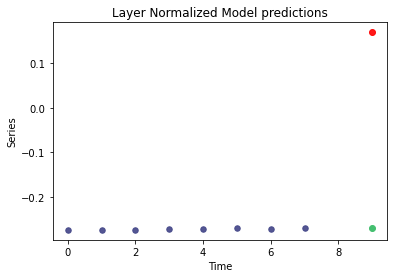

In [46]:
create_predictions_plot(model, model_name="Layer Normalized")

In [47]:
print("Successful")

Successful


### GRU with Average Pooling

In [48]:
rnn_units = 64
n_epochs = 20

model = keras.models.Sequential([
    keras.layers.AveragePooling1D(pool_size = (2)),
    keras.layers.GRU(rnn_units, return_sequences=True), 
    keras.layers.GRU(rnn_units, return_sequences=False),
    keras.layers.Dense(1)
])


model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

In [49]:
log_dir_name = log_dir_names()
early_stopping = keras.callbacks.EarlyStopping(patience=10)
callbacks = [keras.callbacks.TensorBoard(log_dir_name)]

model.fit(X_train, y_train, 
              validation_data = (X_val, y_val), 
            epochs=n_epochs, 
              callbacks = callbacks)

Epoch 1/20
96/96 [==============================] - 9s 92ms/step - loss: 0.2093 - mean_squared_error: 0.2093 - val_loss: 0.7218 - val_mean_squared_error: 0.7218
Epoch 2/20
96/96 [==============================] - 2s 17ms/step - loss: 0.0391 - mean_squared_error: 0.0391 - val_loss: 0.4837 - val_mean_squared_error: 0.4837
Epoch 3/20
96/96 [==============================] - 1s 16ms/step - loss: 0.0238 - mean_squared_error: 0.0238 - val_loss: 0.3772 - val_mean_squared_error: 0.3772
Epoch 4/20
96/96 [==============================] - 2s 16ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.2883 - val_mean_squared_error: 0.2883
Epoch 5/20
96/96 [==============================] - 2s 16ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.2226 - val_mean_squared_error: 0.2226
Epoch 6/20
96/96 [==============================] - 2s 16ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.1920 - val_mean_squared_error: 0.1920
Epoch 7/20
96/96 [================

CNN Pooling GRU Model error: 0.06794658468205453


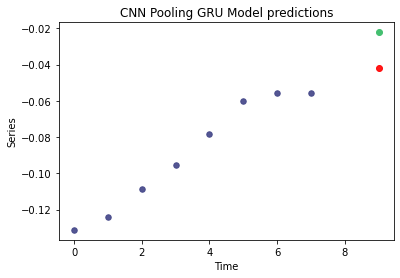

In [59]:
# Test on validation set 
print_val_error(model, model_name="CNN Pooling GRU Model")
create_predictions_plot(model, model_name="CNN Pooling GRU")

In [ ]:
# was 0.004

All of the regularized models have underperformed

### Simple GRU
This section builds and tests a model that uses a simple GRU

In [103]:
# Mean dfunc
def keras_mean(inputs):
    x, y = inputs
    return x+y/2.0

In [72]:
rnn_units = 64
gru_units = 64

# models
model = keras.models.Sequential([
    keras.layers.GRU(rnn_units, return_sequences=True), 
    keras.layers.GRU(rnn_units, return_sequences=True), 
    keras.layers.GRU(rnn_units, return_sequences=False),
    keras.layers.Dense(1)
])


In [73]:
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
log_dir_name = "TwoProngedModelBatchNormalization"+log_dir_names()
early_stopping = keras.callbacks.EarlyStopping(patience=10)
callbacks = [keras.callbacks.TensorBoard(log_dir_name)]

model.fit(X_train, y_train, 
              validation_data = (X_val, y_val), 
            epochs=n_epochs, 
              callbacks = callbacks)

Epoch 1/20
96/96 [==============================] - 10s 105ms/step - loss: 0.1367 - mean_squared_error: 0.1367 - val_loss: 0.5514 - val_mean_squared_error: 0.5514
Epoch 2/20
96/96 [==============================] - 4s 38ms/step - loss: 0.0331 - mean_squared_error: 0.0331 - val_loss: 0.3451 - val_mean_squared_error: 0.3451
Epoch 3/20
96/96 [==============================] - 4s 38ms/step - loss: 0.0189 - mean_squared_error: 0.0189 - val_loss: 0.2866 - val_mean_squared_error: 0.2866
Epoch 4/20
96/96 [==============================] - 4s 38ms/step - loss: 0.0177 - mean_squared_error: 0.0177 - val_loss: 0.2220 - val_mean_squared_error: 0.2220
Epoch 5/20
96/96 [==============================] - 4s 38ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.1885 - val_mean_squared_error: 0.1885
Epoch 6/20
96/96 [==============================] - 4s 39ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.1682 - val_mean_squared_error: 0.1682
Epoch 7/20
96/96 [==============

TwoProngedModel Model error: 0.06270751916062706


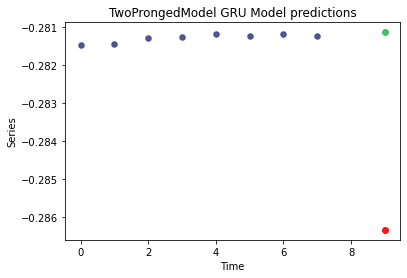

In [75]:
# Test on validation set 
print_val_error(model, model_name="TwoProngedModel Model")
create_predictions_plot(model, model_name="TwoProngedModel GRU")

## Final Comparisons
This final section considers all the different models that are considered upto and will consider some advanced ones too!

In [23]:
# Units Constant 
rnn_units = 64 
n_epochs = 20

### Baseline
Baseline or Naive Model

In [25]:
y_preds = X_val[:, -1]
baseline_error = keras.losses.mean_squared_error(y_preds.squeeze(), y_val.squeeze()).numpy()
print("BaselineError:",baseline_error)

BaselineError: 0.006381828862523554


In [50]:
models_error["Baseline"] = 0.006381828862523553

### Simple RNN 
A very Simple 3-layered Rnn

In [30]:
# Model name
model_name = "Simple_RNN"
time = datetime.now().strftime("%H-%M-%S")
model_path = "./final_logs/"+model_name+"_"+time
# Simple RNN
model = keras.models.Sequential([
    keras.layers.SimpleRNN(rnn_units, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(rnn_units, return_sequences=True),
    keras.layers.SimpleRNN(rnn_units, return_sequences=False),
    keras.layers.Dense(1)
    
])

# Model Compiling
model.compile(loss="mean_squared_error", optimizer="adam")

# Model fitting
model.fit(X_train, y_train, 
         validation_data = (X_val, y_val), 
         epochs = n_epochs, 
         callbacks = [keras.callbacks.EarlyStopping(patience=10), 
                     keras.callbacks.TensorBoard(model_path)])

Epoch 1/20
 1/96 [..............................] - ETA: 0s - loss: 0.3132WARNING:tensorflow:From C:\Users\aadityachaitanya\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
96/96 [==============================] - 3s 31ms/step - loss: 0.2158 - val_loss: 0.7648
Epoch 2/20
96/96 [==============================] - 1s 15ms/step - loss: 0.0361 - val_loss: 0.4649
Epoch 3/20
96/96 [==============================] - 2s 16ms/step - loss: 0.0184 - val_loss: 0.3798
Epoch 4/20
96/96 [==============================] - 2s 16ms/step - loss: 0.0124 - val_loss: 0.3202
Epoch 5/20
96/96 [==============================] - 2s 16ms/step - loss: 0.0120 - val_loss: 0.2617
Epoch 6/20
96/96 [==============================] - 2s 16ms/step - loss: 0.0096 - val_loss: 0.2276
Epoch 7/20
96/96 [==============================] 

In [31]:
print_val_error(model, model_name="Simple RNN")

Simple RNN error: 0.12424653821665009


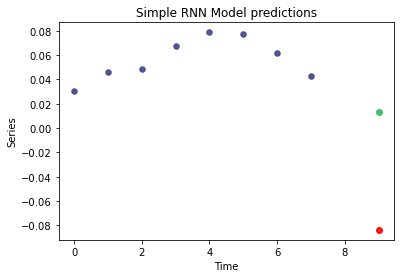

In [32]:
create_predictions_plot(model, model_name="Simple RNN")

In [49]:
# Tallying the error
models_error["SimpleRNN"] = 0.12424653821665009

### GRU
A simple 3 layered GRU model

In [34]:
# Model name
model_name = "GRU"
time = datetime.now().strftime("%H-%M-%S")
model_path = "./final_logs/"+model_name+"_"+time
# Simple RNN
model = keras.models.Sequential([
    keras.layers.GRU(rnn_units, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(rnn_units, return_sequences=True),
    keras.layers.GRU(rnn_units, return_sequences=False),
    keras.layers.Dense(1)
    
])

# Model Compiling
model.compile(loss="mean_squared_error", optimizer="adam")

# Model fitting
model.fit(X_train, y_train, 
         validation_data = (X_val, y_val), 
         epochs = n_epochs, 
         callbacks = [keras.callbacks.EarlyStopping(patience=10), 
                     keras.callbacks.TensorBoard(model_path)])

Epoch 1/20
96/96 [==============================] - 13s 133ms/step - loss: 0.2346 - val_loss: 0.6731
Epoch 2/20
96/96 [==============================] - 5s 47ms/step - loss: 0.0486 - val_loss: 0.4900
Epoch 3/20
96/96 [==============================] - 4s 39ms/step - loss: 0.0317 - val_loss: 0.3311
Epoch 4/20
96/96 [==============================] - 5s 56ms/step - loss: 0.0147 - val_loss: 0.2525
Epoch 5/20
96/96 [==============================] - 5s 48ms/step - loss: 0.0103 - val_loss: 0.3651
Epoch 6/20
96/96 [==============================] - 4s 38ms/step - loss: 0.0135 - val_loss: 0.1695
Epoch 7/20
96/96 [==============================] - 4s 44ms/step - loss: 0.0043 - val_loss: 0.1431
Epoch 8/20
96/96 [==============================] - 4s 41ms/step - loss: 0.0054 - val_loss: 0.1444
Epoch 9/20
96/96 [==============================] - 4s 46ms/step - loss: 0.0052 - val_loss: 0.1256
Epoch 10/20
96/96 [==============================] - 4s 41ms/step - loss: 0.0034 - val_loss: 0.1138
Epoch 1

In [35]:
print_val_error(model, model_name="GRU")

GRU error: 0.10092323652974153


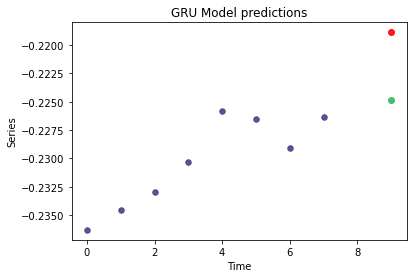

In [38]:
create_predictions_plot(model, model_name="GRU")

In [48]:
# Tallying the error
models_error["GRU"] = 0.10092323652974153

### LSTM
A three layered LSTM model

In [ ]:
# Model name
model_name = "LSTM"
time = datetime.now().strftime("%H-%M-%S")
model_path = "./final_logs/"+model_name+"_"+time
# Simple RNN
model = keras.models.Sequential([
    keras.layers.LSTM(rnn_units, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(rnn_units, return_sequences=True),
    keras.layers.LSTM(rnn_units, return_sequences=False),
    keras.layers.Dense(1)
    
])

# Model Compiling
model.compile(loss="mean_squared_error", optimizer="adam")

# Model fitting
model.fit(X_train, y_train, 
         validation_data = (X_val, y_val), 
         epochs = n_epochs, 
         callbacks = [keras.callbacks.EarlyStopping(patience=10), 
                     keras.callbacks.TensorBoard(model_path)])

Epoch 1/20
 1/96 [..............................] - ETA: 0s - loss: 0.0882WARNING:tensorflow:From C:\Users\aadityachaitanya\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


In [ ]:
print_val_error(model, model_name=model_name)

In [ ]:
create_predictions_plot(model, model_name=model_name)

In [ ]:
models_error[model_name] = 

### Dropout
A GRU model with dropout

In [32]:
# Model name
model_name = "GRU_Dropout_0.1"
time = datetime.now().strftime("%H-%M-%S")
model_path = "./final_logs/"+model_name+"_"+time
# Simple RNN
dropout_value = 0.1
recurrent_dropout_value = 0.1

model = keras.models.Sequential([
    keras.layers.GRU(rnn_units, return_sequences=True, input_shape=[None, 1], 
                    dropout=dropout_value, recurrent_dropout=recurrent_dropout_value),
    keras.layers.GRU(rnn_units, return_sequences=True, 
                    dropout=dropout_value, recurrent_dropout=recurrent_dropout_value),
    keras.layers.GRU(rnn_units, return_sequences=False, 
                    dropout=dropout_value, recurrent_dropout=recurrent_dropout_value),
    keras.layers.Dense(1)
    
])

# Model Compiling
model.compile(loss="mean_squared_error", optimizer="adam")

# Model fitting
model.fit(X_train, y_train, 
         validation_data = (X_val, y_val), 
         epochs = n_epochs, 
         callbacks = [keras.callbacks.EarlyStopping(patience=10), 
                     keras.callbacks.TensorBoard(model_path)])

Epoch 1/20
 1/96 [..............................] - ETA: 0s - loss: 1.5756WARNING:tensorflow:From C:\Users\aadityachaitanya\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
96/96 [==============================] - 9s 89ms/step - loss: 0.1850 - val_loss: 0.6259
Epoch 2/20
96/96 [==============================] - 6s 62ms/step - loss: 0.0596 - val_loss: 0.4942
Epoch 3/20
96/96 [==============================] - 6s 61ms/step - loss: 0.0439 - val_loss: 0.3885
Epoch 4/20
96/96 [==============================] - 6s 60ms/step - loss: 0.0333 - val_loss: 0.3306
Epoch 5/20
96/96 [==============================] - 6s 64ms/step - loss: 0.0208 - val_loss: 0.2567
Epoch 6/20
96/96 [==============================] - 6s 61ms/step - loss: 0.0230 - val_loss: 0.2509
Epoch 7/20
96/96 [==============================] 

In [33]:
print_val_error(model, model_name=model_name)

GRU_Dropout_0.1 error: 0.16289097820928836


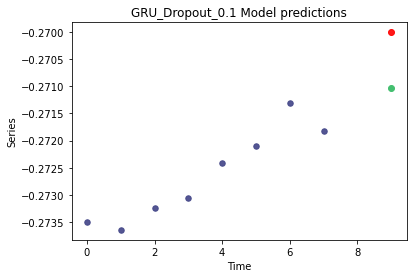

In [36]:
create_predictions_plot(model, model_name=model_name)

In [47]:
models_error["GRU_Dropout_0"] = 0.16289097820928836

### Layer and Batch Normalization
A GRU model with layer and Batch Regularization

In [38]:
# Model name
model_name = "Layer_Batch_Normalization"
time = datetime.now().strftime("%H-%M-%S")
model_path = "./final_logs/"+model_name+"_"+time

# Layer and Batch Normalization


model = keras.models.Sequential([
    keras.layers.BatchNormalization(),
    keras.layers.GRU(rnn_units, return_sequences=True, input_shape=[None, 1], 
                    dropout=dropout_value, recurrent_dropout=recurrent_dropout_value),
    keras.layers.LayerNormalization(),
    keras.layers.GRU(rnn_units, return_sequences=True, 
                    dropout=dropout_value, recurrent_dropout=recurrent_dropout_value),
    keras.layers.LayerNormalization(),
    keras.layers.GRU(rnn_units, return_sequences=False, 
                    dropout=dropout_value, recurrent_dropout=recurrent_dropout_value),
    keras.layers.LayerNormalization(),
    keras.layers.Dense(1)
    
])

# Model Compiling
model.compile(loss="mean_squared_error", optimizer="adam")

# Model fitting
model.fit(X_train, y_train, 
         validation_data = (X_val, y_val), 
         epochs = n_epochs, 
         callbacks = [keras.callbacks.EarlyStopping(patience=10), 
                     keras.callbacks.TensorBoard(model_path)])

Epoch 1/20
96/96 [==============================] - 22s 231ms/step - loss: 0.8510 - val_loss: 1.9239
Epoch 2/20
96/96 [==============================] - 6s 63ms/step - loss: 0.5657 - val_loss: 1.7899
Epoch 3/20
96/96 [==============================] - 7s 69ms/step - loss: 0.5076 - val_loss: 1.4813
Epoch 4/20
96/96 [==============================] - 9s 91ms/step - loss: 0.5673 - val_loss: 1.6556
Epoch 5/20
96/96 [==============================] - 7s 75ms/step - loss: 0.5307 - val_loss: 1.6442
Epoch 6/20
96/96 [==============================] - 7s 73ms/step - loss: 0.4891 - val_loss: 1.5838
Epoch 7/20
96/96 [==============================] - 7s 69ms/step - loss: 0.4433 - val_loss: 1.3214
Epoch 8/20
96/96 [==============================] - 7s 70ms/step - loss: 0.4311 - val_loss: 1.4087
Epoch 9/20
96/96 [==============================] - 8s 81ms/step - loss: 0.4273 - val_loss: 1.4957
Epoch 10/20
96/96 [==============================] - 10s 99ms/step - loss: 0.4838 - val_loss: 1.3185
Epoch 

In [39]:
print_val_error(model, model_name=model_name)

Layer_Batch_Normalization error: 1.1805192609175124


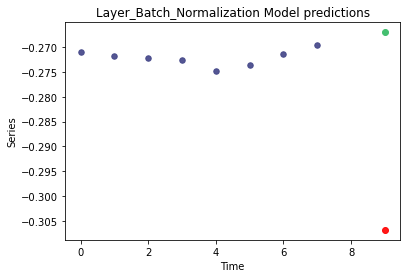

In [40]:
create_predictions_plot(model, model_name=model_name)

In [46]:
models_error["Layer_Batch_Normalization"] = 1.1805192609175124

### Average Pooling
A GRU model with Average Pooling

In [28]:
# Model name
model_name = "Average_Pooling_valid"
time = datetime.now().strftime("%H-%M-%S")
model_path = "./final_logs/"+model_name+"_"+time

# Average Pooling


model = keras.models.Sequential([
    keras.layers.AveragePooling1D(pool_size=(2),  input_shape=[None, 1]), 
    keras.layers.GRU(rnn_units, return_sequences=True),
    keras.layers.GRU(rnn_units, return_sequences=True),
    keras.layers.GRU(rnn_units, return_sequences=False),
    keras.layers.Dense(1)
    
])

# Model Compiling
model.compile(loss="mean_squared_error", optimizer="adam")

# Model fitting
model.fit(X_train, y_train, 
         validation_data = (X_val, y_val), 
         epochs = n_epochs, 
         callbacks = [keras.callbacks.EarlyStopping(patience=10), 
                     keras.callbacks.TensorBoard(model_path)])

Epoch 1/20
 1/96 [..............................] - ETA: 0s - loss: 2.9501WARNING:tensorflow:From C:\Users\aadityachaitanya\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
96/96 [==============================] - 5s 51ms/step - loss: 0.1908 - val_loss: 0.5508
Epoch 2/20
96/96 [==============================] - 2s 20ms/step - loss: 0.0287 - val_loss: 0.3798
Epoch 3/20
96/96 [==============================] - 2s 19ms/step - loss: 0.0281 - val_loss: 0.3079
Epoch 4/20
96/96 [==============================] - 2s 21ms/step - loss: 0.0156 - val_loss: 0.2416
Epoch 5/20
96/96 [==============================] - 2s 20ms/step - loss: 0.0134 - val_loss: 0.1962
Epoch 6/20
96/96 [==============================] - 2s 20ms/step - loss: 0.0142 - val_loss: 0.2340
Epoch 7/20
96/96 [==============================] 

In [29]:
print_val_error(model, model_name=model_name)

Average_Pooling_valid error: 0.08779630333806168


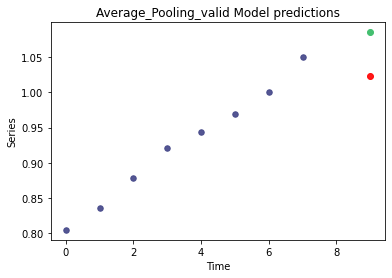

In [38]:
create_predictions_plot(model, model_name=model_name)

In [45]:
models_error["Average_Pooling_valid"] = 0.08779630333806168

In [ ]:
#models_error["Average_Pooling_same"] = 

### Convolutional Layers
A Convolutional Model with Max Pooling

In [91]:
# Model name
model_name = "Convolution_3"
time = datetime.now().strftime("%H-%M-%S")
model_path = "./final_logs/"+model_name+"_"+time

# CNN
n_filters = 8
kernel_size = 2

model = keras.models.Sequential([
    keras.layers.Conv1D(n_filters, kernel_size, input_shape=[8, 1],
                       activation="relu"), 
    keras.layers.MaxPooling1D(pool_size=(2), padding="same"), 
    keras.layers.Conv1D(n_filters, kernel_size, activation="relu"), 
    keras.layers.MaxPooling1D(pool_size=(2), padding="same"),
    keras.layers.Conv1D(n_filters, kernel_size, activation="relu"),
    keras.layers.Flatten(), 
    keras.layers.Dense(rnn_units), 
    keras.layers.Dense(1)
    
])
# Model Compiling
model.compile(loss="mean_squared_error", optimizer="adam")

# Model fitting
model.fit(X_train, y_train, 
         validation_data = (X_val, y_val), 
         epochs = n_epochs, 
         callbacks = [keras.callbacks.EarlyStopping(patience=10), 
                     keras.callbacks.TensorBoard(model_path)])

Epoch 1/20
96/96 [==============================] - 3s 28ms/step - loss: 0.9888 - val_loss: 1.9536
Epoch 2/20
96/96 [==============================] - 0s 3ms/step - loss: 0.0998 - val_loss: 0.0350
Epoch 3/20
96/96 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0332
Epoch 4/20
96/96 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.0368
Epoch 5/20
96/96 [==============================] - 0s 5ms/step - loss: 0.0060 - val_loss: 0.0402
Epoch 6/20
96/96 [==============================] - 1s 6ms/step - loss: 0.0036 - val_loss: 0.0303
Epoch 7/20
96/96 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0324
Epoch 8/20
96/96 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0268
Epoch 9/20
96/96 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0285
Epoch 10/20
96/96 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0402
Epoch 11/20
96/96 

In [92]:
print_val_error(model, model_name=model_name)

Convolution_3 error: 0.03241743118412501


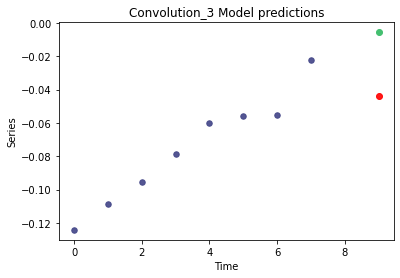

In [99]:
create_predictions_plot(model, model_name=model_name)

In [44]:
models_error["Convolution_3"] = 0.03241743118412501

### Stacked Network
A Stacked GRU model

In [28]:
# Model name
model_name = "Stacked_Network"
time = datetime.now().strftime("%H-%M-%S")
model_path = "./final_logs/"+model_name+"_"+time

# Average Pooling
reduced_rnn_units = int(rnn_units/4)

model = keras.models.Sequential([
    keras.layers.GRU(reduced_rnn_units, return_sequences=True),
    keras.layers.GRU(reduced_rnn_units, return_sequences=True),
    keras.layers.GRU(reduced_rnn_units, return_sequences=True),
    keras.layers.GRU(reduced_rnn_units, return_sequences=True),
    keras.layers.GRU(reduced_rnn_units, return_sequences=True),
    keras.layers.GRU(reduced_rnn_units, return_sequences=True),
    keras.layers.GRU(reduced_rnn_units, return_sequences=True),
    keras.layers.GRU(reduced_rnn_units, return_sequences=True),
    keras.layers.GRU(reduced_rnn_units, return_sequences=False),
    keras.layers.Dense(1)
    
])

# Model Compiling
model.compile(loss="mean_squared_error", optimizer="adam")

# Model fitting
model.fit(X_train, y_train, 
         validation_data = (X_val, y_val), 
         epochs = n_epochs, 
         callbacks = [keras.callbacks.EarlyStopping(patience=10), 
                     keras.callbacks.TensorBoard(model_path)])

Epoch 1/20
 1/96 [..............................] - ETA: 0s - loss: 0.1057WARNING:tensorflow:From C:\Users\aadityachaitanya\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
96/96 [==============================] - 6s 68ms/step - loss: 0.6207 - val_loss: 1.8577
Epoch 2/20
96/96 [==============================] - 3s 34ms/step - loss: 0.2164 - val_loss: 1.4399
Epoch 3/20
96/96 [==============================] - 3s 36ms/step - loss: 0.1512 - val_loss: 1.2593
Epoch 4/20
96/96 [==============================] - 3s 36ms/step - loss: 0.1182 - val_loss: 1.1341
Epoch 5/20
96/96 [==============================] - 3s 35ms/step - loss: 0.0960 - val_loss: 1.0527
Epoch 6/20
96/96 [==============================] - 4s 38ms/step - loss: 0.0823 - val_loss: 1.0593
Epoch 7/20
96/96 [==============================] 

In [29]:
print_val_error(model, model_name=model_name)

Stacked_Network error: 0.4763623315561812


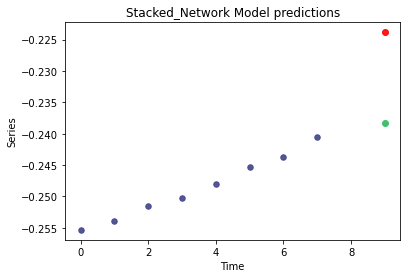

In [30]:
create_predictions_plot(model, model_name=model_name)

In [43]:
models_error["Stacked_Network"] = 0.4763623315561812

### Combined Model
A GRU model with top layers using Convolutional Layers

In [32]:
# Convolutional and GRU stacked 
# Model name
model_name = "Combiend_model_1"
time = datetime.now().strftime("%H-%M-%S")
model_path = "./final_logs/"+model_name+"_"+time

# CNN
n_filters = 8
kernel_size = 2
n_epochs = 20
model = keras.models.Sequential([
    keras.layers.Conv1D(n_filters, kernel_size, input_shape=[8, 1],
                       activation="relu"), 
    keras.layers.MaxPooling1D(pool_size=(2), padding="same"), 
    keras.layers.Conv1D(n_filters, kernel_size, activation="relu"), 
    keras.layers.MaxPooling1D(pool_size=(2), padding="same"),
    keras.layers.Conv1D(n_filters, kernel_size, activation="relu"),
    keras.layers.GRU(rnn_units, return_sequences=True),
    keras.layers.GRU(rnn_units, return_sequences=True),
    keras.layers.GRU(rnn_units, return_sequences=False),
    keras.layers.Dense(1)
    
])
# Model Compiling
model.compile(loss="mean_squared_error", optimizer="adam")

# Model fitting
model.fit(X_train, y_train, 
         validation_data = (X_val, y_val), 
         epochs = n_epochs, 
         callbacks = [keras.callbacks.EarlyStopping(patience=10), 
                     keras.callbacks.TensorBoard(model_path)])

Epoch 1/20
96/96 [==============================] - 11s 114ms/step - loss: 0.5852 - val_loss: 0.5798
Epoch 2/20
96/96 [==============================] - 1s 11ms/step - loss: 0.0338 - val_loss: 0.3696
Epoch 3/20
96/96 [==============================] - 1s 11ms/step - loss: 0.0213 - val_loss: 0.3980
Epoch 4/20
96/96 [==============================] - 1s 12ms/step - loss: 0.0158 - val_loss: 0.2306
Epoch 5/20
96/96 [==============================] - 1s 14ms/step - loss: 0.0108 - val_loss: 0.2176
Epoch 6/20
96/96 [==============================] - 1s 11ms/step - loss: 0.0089 - val_loss: 0.1846
Epoch 7/20
96/96 [==============================] - 1s 11ms/step - loss: 0.0094 - val_loss: 0.1596
Epoch 8/20
96/96 [==============================] - 1s 12ms/step - loss: 0.0054 - val_loss: 0.1517
Epoch 9/20
96/96 [==============================] - 1s 13ms/step - loss: 0.0074 - val_loss: 0.1298
Epoch 10/20
96/96 [==============================] - 1s 13ms/step - loss: 0.0040 - val_loss: 0.1514
Epoch 1

In [33]:
print_val_error(model, model_name=model_name)

Combiend_model_1 error: 0.07841926975143017


In [35]:
models_error[model_name] = 0.07841926975143017

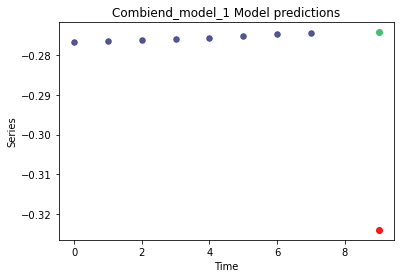

In [42]:
create_predictions_plot(model, model_name=model_name)

### Comparing Errors

In [56]:
errors_df = pd.DataFrame.from_dict(models_error, orient="index" ,columns=["Error"])

In [53]:
models_error

{'DecisionTreeRegressor': 0.13314048355595137,
 'RandomForestRegressor': 0.14514600484267437,
 'ExtraTreesRegressor': 0.1377419811742491,
 'SVR': 1.2977672460380496,
 'Combiend_model_1': 0.07841926975143017,
 'Stacked_Network': 0.4763623315561812,
 'Convolution_3': 0.03241743118412501,
 'Average_Pooling_valid': 0.08779630333806168,
 'Layer_Batch_Normalization': 1.1805192609175124,
 'GRU_Dropout_0': 0.16289097820928836,
 'GRU': 0.10092323652974153,
 'SimpleRNN': 0.12424653821665009,
 'Baseline': 0.006381828862523553}

<AxesSubplot:>

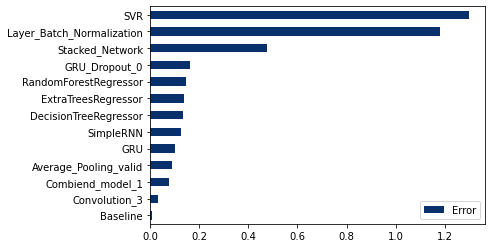

In [63]:
errors_df.sort_values(ascending=True, by="Error").plot(kind="barh", cmap="Blues_r")

<AxesSubplot:>

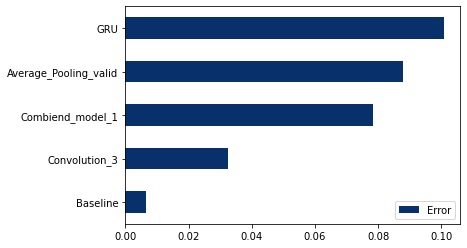

In [65]:
# Lets consider only the top 5 models 
errors_df.sort_values(ascending=True, by="Error").head().plot(kind="barh", cmap="Blues_r")

In [66]:
# Only the convolutional model has a chance of making this work
# Consider Convolutional model for 40 epochs

In [68]:
# Model name
model_name = "Convolution_4_40_epochs"
time = datetime.now().strftime("%H-%M-%S")
model_path = "./final_logs/"+model_name+"_"+time

# CNN
n_filters = 8
kernel_size = 2
n_epochs = 60

model = keras.models.Sequential([
    keras.layers.Conv1D(n_filters, kernel_size, input_shape=[8, 1],
                       activation="relu"), 
    keras.layers.MaxPooling1D(pool_size=(2), padding="same"), 
    keras.layers.Conv1D(n_filters, kernel_size, activation="relu"), 
    keras.layers.MaxPooling1D(pool_size=(2), padding="same"),
    keras.layers.Conv1D(n_filters, kernel_size, activation="relu"),
    keras.layers.Flatten(), 
    keras.layers.Dense(rnn_units), 
    keras.layers.Dense(1)
    
])
# Model Compiling
model.compile(loss="mean_squared_error", optimizer="adam")

# Model fitting
model.fit(X_train, y_train, 
         validation_data = (X_val, y_val), 
         epochs = n_epochs, 
         callbacks = [keras.callbacks.EarlyStopping(patience=10), 
                     keras.callbacks.TensorBoard(model_path)])

Epoch 1/60
96/96 [==============================] - 2s 19ms/step - loss: 0.3899 - val_loss: 0.0191
Epoch 2/60
96/96 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0219
Epoch 3/60
96/96 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0167
Epoch 4/60
96/96 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0148
Epoch 5/60
96/96 [==============================] - 1s 6ms/step - loss: 0.0018 - val_loss: 0.0142
Epoch 6/60
96/96 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0178
Epoch 7/60
96/96 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0166
Epoch 8/60
96/96 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0135
Epoch 9/60
96/96 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0116
Epoch 10/60
96/96 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0131
Epoch 11/60
96/96 

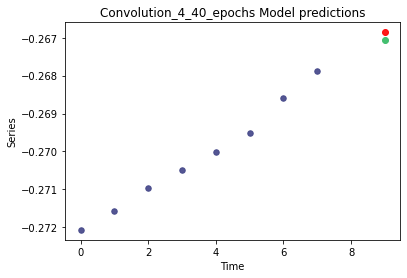

In [77]:
create_predictions_plot(model, model_name=model_name)

### Grid Search CV

In [40]:
def build_convolutional_model(n_stacks=2, n_dense_layers=1, dense_units=64, 
                             n_filters=8, kernel_size=1, optimizer="adam"):
    # Model
    model = model = keras.models.Sequential()
    model.add(keras.layers.Conv1D(n_filters, kernel_size, input_shape=[8, 1],
                       activation="relu"))

    # Stack
    for iteration in range(n_stacks-1):
        model.add(keras.layers.MaxPooling1D(pool_size=(2), padding="same"))
        model.add(keras.layers.Conv1D(n_filters, kernel_size, activation="relu"))

    # Flatten
    model.add(keras.layers.Flatten())

    # Dense layers 
    for dense_iteration in range(n_dense_layers):
        model.add(keras.layers.Dense(dense_units, activation="relu"))


    model.add(keras.layers.Dense(1))
    
    # Compile 
    model.compile(loss="mean_squared_error", optimizer=optimizer)
    return model

In [27]:
# Search Ranges
n_stacks = np.arange(1, 4).tolist()
n_dense_layers = np.arange(4).tolist()
dense_units = (2**(np.arange(8))).tolist()
n_filters = (2*np.arange(6)).tolist() 
kernel_size = np.arange(1, 3).tolist()
optimizers = ["adam", "nadam"]

In [28]:
n_filters 

[0, 2, 4, 6, 8, 10]

In [30]:
# Param Grid 
param_grid = {
    "n_stacks":n_stacks,
    "n_dense_layers":n_dense_layers,
    "dense_units":dense_units, 
    #"n_filters":n_filters, # Problem here
    #"kernel_size":kernel_size, Error here
    "optimizer":optimizers
}

In [28]:
# Test
param_grid = {
    "n_stacks":n_stacks,
    "n_dense_layers":n_dense_layers,
    "dense_units":dense_units, 
    "optimizer":optimizers
}

In [29]:
# Keras Wrapper 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
estimator = KerasRegressor(build_convolutional_model, verbose=1)

In [30]:
# Grid Search CV
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(estimator, param_grid, cv=3)
gs.fit(X_train, y_train, epochs = 20)

Epoch 1/20
64/64 [==============================] - 0s 2ms/step - loss: 1.0434
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 0.3362
Epoch 3/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0686
Epoch 4/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0065
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch 9/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 10/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 11/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 12/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 13/20
64/64 [==============================

64/64 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 19/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 20/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 1/20
64/64 [==============================] - 0s 2ms/step - loss: 1.6936
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 1.1502
Epoch 3/20
64/64 [==============================] - 0s 2ms/step - loss: 0.4642
Epoch 4/20
64/64 [==============================] - 0s 2ms/step - loss: 0.1093
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0236
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 7/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 8/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 9/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 10/20
64/64 [==============================] - 0s 2ms/s

64/64 [==============================] - 0s 2ms/step - loss: 4.8812e-04
Epoch 17/20
64/64 [==============================] - 0s 2ms/step - loss: 5.1211e-04
Epoch 18/20
64/64 [==============================] - 0s 2ms/step - loss: 5.0176e-04
Epoch 19/20
64/64 [==============================] - 0s 2ms/step - loss: 5.1820e-04
Epoch 20/20
32/32 [==============================] - 0s 1ms/step - loss: 8.4093e-04
Epoch 1/20
64/64 [==============================] - 0s 2ms/step - loss: 0.5489
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 0.1676
Epoch 3/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0297
Epoch 4/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 8/20
64/64 [=====================

64/64 [==============================] - 0s 2ms/step - loss: 1.3317
Epoch 13/20
64/64 [==============================] - 0s 2ms/step - loss: 1.3315
Epoch 14/20
64/64 [==============================] - 0s 2ms/step - loss: 1.3315
Epoch 15/20
64/64 [==============================] - 0s 2ms/step - loss: 1.3315
Epoch 16/20
64/64 [==============================] - 0s 2ms/step - loss: 1.3315
Epoch 17/20
64/64 [==============================] - 0s 2ms/step - loss: 1.3316
Epoch 18/20
64/64 [==============================] - 0s 2ms/step - loss: 1.3316
Epoch 19/20
64/64 [==============================] - 0s 2ms/step - loss: 1.3315
Epoch 20/20
32/32 [==============================] - 0s 1ms/step - loss: 0.8679
Epoch 1/20
64/64 [==============================] - 0s 2ms/step - loss: 1.1303
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 1.0894
Epoch 3/20
64/64 [==============================] - 0s 2ms/step - loss: 1.0624
Epoch 4/20
64/64 [==============================] - 0s 

64/64 [==============================] - 0s 2ms/step - loss: 0.1218
Epoch 9/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0414
Epoch 10/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 11/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0076
Epoch 12/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 13/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 14/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 15/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 16/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 17/20
64/64 [==============================] - 0s 4ms/step - loss: 9.0768e-04
Epoch 18/20
64/64 [==============================] - 0s 2ms/step - loss: 9.8181e-04
Epoch 19/20
64/64 [==============================] - 0s 2ms/step - loss: 8.6862e-04
Epoch 20/20
32/32 [======================

64/64 [==============================] - 0s 3ms/step - loss: 1.0477
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 1.0477
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 1.0478
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 1.0477
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 1.0478
Epoch 9/20
64/64 [==============================] - 0s 2ms/step - loss: 1.0477
Epoch 10/20
64/64 [==============================] - 0s 2ms/step - loss: 1.0477
Epoch 11/20
64/64 [==============================] - 0s 2ms/step - loss: 1.0477
Epoch 12/20
64/64 [==============================] - 0s 2ms/step - loss: 1.0478
Epoch 13/20
64/64 [==============================] - 0s 2ms/step - loss: 1.0477
Epoch 14/20
64/64 [==============================] - 0s 2ms/step - loss: 1.0479
Epoch 15/20
64/64 [==============================] - 0s 2ms/step - loss: 1.0478
Epoch 16/20
64/64 [==============================] - 0s 2

32/32 [==============================] - 0s 2ms/step - loss: 1.4350
Epoch 1/20
64/64 [==============================] - 0s 2ms/step - loss: 1.3345
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 1.3329
Epoch 3/20
64/64 [==============================] - 0s 2ms/step - loss: 1.3323
Epoch 4/20
64/64 [==============================] - 0s 2ms/step - loss: 1.3319
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 1.3317
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 1.3317
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 1.3316
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 1.3315
Epoch 9/20
64/64 [==============================] - 0s 2ms/step - loss: 1.3315
Epoch 10/20
64/64 [==============================] - 0s 2ms/step - loss: 1.3316
Epoch 11/20
64/64 [==============================] - 0s 2ms/step - loss: 1.3317
Epoch 12/20
64/64 [==============================] - 0s 2ms/s

64/64 [==============================] - 0s 2ms/step - loss: 1.0018
Epoch 18/20
64/64 [==============================] - 0s 2ms/step - loss: 0.9892
Epoch 19/20
64/64 [==============================] - 0s 2ms/step - loss: 0.9768
Epoch 20/20
32/32 [==============================] - 0s 2ms/step - loss: 0.5681
Epoch 1/20
64/64 [==============================] - 0s 2ms/step - loss: 1.1507
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 1.1503
Epoch 3/20
64/64 [==============================] - 0s 2ms/step - loss: 1.1502
Epoch 4/20
64/64 [==============================] - 0s 2ms/step - loss: 1.1501
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 1.1500
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 1.1500
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 1.1500
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 1.1500
Epoch 9/20
64/64 [==============================] - 0s 3ms/s

64/64 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 14/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 15/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 16/20
64/64 [==============================] - 0s 1ms/step - loss: 0.0043
Epoch 17/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 18/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 19/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 20/20
32/32 [==============================] - 0s 1ms/step - loss: 0.0035
Epoch 1/20
64/64 [==============================] - 0s 1ms/step - loss: 0.8692
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 0.4922
Epoch 3/20
64/64 [==============================] - 0s 2ms/step - loss: 0.2050
Epoch 4/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0583
Epoch 5/20
64/64 [==============================] - 0s 2

64/64 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 10/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 11/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 12/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 13/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 14/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch 15/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 16/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 17/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 18/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 19/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 20/20
32/32 [==============================] - 0s 1ms/step - loss: 0.0069
Epoch 1/20
64/64 [==============================] - 

64/64 [==============================] - 0s 2ms/step - loss: 1.1903
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 1.1713
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 1.1532
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 1.1361
Epoch 9/20
64/64 [==============================] - 0s 2ms/step - loss: 1.1195
Epoch 10/20
64/64 [==============================] - 0s 2ms/step - loss: 1.1035
Epoch 11/20
64/64 [==============================] - 0s 2ms/step - loss: 1.0878
Epoch 12/20
64/64 [==============================] - 0s 2ms/step - loss: 1.0727
Epoch 13/20
64/64 [==============================] - 0s 3ms/step - loss: 1.0580
Epoch 14/20
64/64 [==============================] - 0s 3ms/step - loss: 1.0437
Epoch 15/20
64/64 [==============================] - 0s 3ms/step - loss: 1.0300
Epoch 16/20
64/64 [==============================] - 0s 2ms/step - loss: 1.0167
Epoch 17/20
64/64 [==============================] - 0s 

64/64 [==============================] - 0s 2ms/step - loss: 2.3325
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 1.7600
Epoch 3/20
64/64 [==============================] - 0s 2ms/step - loss: 1.4064
Epoch 4/20
64/64 [==============================] - 0s 2ms/step - loss: 1.1436
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 0.9267
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 0.8021
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 0.6670
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 0.4952
Epoch 9/20
64/64 [==============================] - 0s 2ms/step - loss: 0.2985
Epoch 10/20
64/64 [==============================] - 0s 2ms/step - loss: 0.1394
Epoch 11/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0558
Epoch 12/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0213
Epoch 13/20
64/64 [==============================] - 0s 2ms/

64/64 [==============================] - 0s 2ms/step - loss: 1.1499
Epoch 19/20
64/64 [==============================] - 0s 2ms/step - loss: 1.1500
Epoch 20/20
32/32 [==============================] - 0s 1ms/step - loss: 1.2299
Epoch 1/20
64/64 [==============================] - 0s 2ms/step - loss: 1.1132
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 0.9789
Epoch 3/20
64/64 [==============================] - 0s 2ms/step - loss: 0.9567
Epoch 4/20
64/64 [==============================] - 0s 2ms/step - loss: 0.9373
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 0.9191
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 0.9023
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 0.8864
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 0.8726
Epoch 9/20
64/64 [==============================] - 0s 2ms/step - loss: 0.8575
Epoch 10/20
64/64 [==============================] - 0s 2ms/s

64/64 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 12/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 13/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 14/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 15/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 16/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 17/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 18/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 19/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 20/20
32/32 [==============================] - 0s 1ms/step - loss: 0.0048
Epoch 1/20
64/64 [==============================] - 0s 2ms/step - loss: 1.2885
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 1.1140
Epoch 3/20
64/64 [==============================] - 0s

64/64 [==============================] - 0s 2ms/step - loss: 1.3318
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 1.3316
Epoch 9/20
64/64 [==============================] - 0s 2ms/step - loss: 1.3315
Epoch 10/20
64/64 [==============================] - 0s 2ms/step - loss: 1.3316
Epoch 11/20
64/64 [==============================] - 0s 2ms/step - loss: 1.3318
Epoch 12/20
64/64 [==============================] - 0s 2ms/step - loss: 1.3316
Epoch 13/20
64/64 [==============================] - 0s 2ms/step - loss: 1.3315
Epoch 14/20
64/64 [==============================] - 0s 2ms/step - loss: 1.3317
Epoch 15/20
64/64 [==============================] - 0s 2ms/step - loss: 1.3316
Epoch 16/20
64/64 [==============================] - 0s 2ms/step - loss: 1.3316
Epoch 17/20
64/64 [==============================] - 0s 2ms/step - loss: 1.3315
Epoch 18/20
64/64 [==============================] - 0s 2ms/step - loss: 1.3315
Epoch 19/20
64/64 [==============================] - 0

64/64 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 4/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 5/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 6/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 9/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 10/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 11/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 12/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 13/20
64/64 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 14/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 15/20
64/64 [==============================] - 0s 3m

32/32 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 1/20
64/64 [==============================] - 0s 2ms/step - loss: 0.3218
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0843
Epoch 3/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 4/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 6/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 7/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 9/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 10/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 11/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 12/20
64/64 [==============================] - 0s 2ms/s

64/64 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 16/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 17/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 18/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 19/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 20/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 1/20
64/64 [==============================] - 0s 2ms/step - loss: 1.1753
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 0.4879
Epoch 3/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0963
Epoch 4/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 7/20
64/64 [==============================] - 0s 2ms

64/64 [==============================] - 0s 2ms/step - loss: 1.0875
Epoch 12/20
64/64 [==============================] - 0s 2ms/step - loss: 1.0724
Epoch 13/20
64/64 [==============================] - 0s 2ms/step - loss: 1.0578
Epoch 14/20
64/64 [==============================] - 0s 2ms/step - loss: 1.0438
Epoch 15/20
64/64 [==============================] - 0s 2ms/step - loss: 1.0302
Epoch 16/20
64/64 [==============================] - 0s 3ms/step - loss: 1.0171
Epoch 17/20
64/64 [==============================] - 0s 3ms/step - loss: 1.0044
Epoch 18/20
64/64 [==============================] - 0s 4ms/step - loss: 0.9921
Epoch 19/20
64/64 [==============================] - 0s 3ms/step - loss: 0.9801
Epoch 20/20
32/32 [==============================] - 0s 2ms/step - loss: 0.5709
Epoch 1/20
64/64 [==============================] - 0s 2ms/step - loss: 0.6421
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 0.1912
Epoch 3/20
64/64 [==============================] - 0s

64/64 [==============================] - 0s 2ms/step - loss: 1.0043
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 0.9865
Epoch 9/20
64/64 [==============================] - 0s 2ms/step - loss: 0.9698
Epoch 10/20
64/64 [==============================] - 0s 2ms/step - loss: 0.9540
Epoch 11/20
64/64 [==============================] - 0s 2ms/step - loss: 0.9389
Epoch 12/20
64/64 [==============================] - 0s 2ms/step - loss: 0.9247
Epoch 13/20
64/64 [==============================] - 0s 2ms/step - loss: 0.9110
Epoch 14/20
64/64 [==============================] - 0s 2ms/step - loss: 0.8979
Epoch 15/20
64/64 [==============================] - 0s 2ms/step - loss: 0.8854
Epoch 16/20
64/64 [==============================] - 0s 2ms/step - loss: 0.8732
Epoch 17/20
64/64 [==============================] - 0s 2ms/step - loss: 0.8615
Epoch 18/20
64/64 [==============================] - 0s 2ms/step - loss: 0.8501
Epoch 19/20
64/64 [==============================] - 0

64/64 [==============================] - 0s 2ms/step - loss: 0.0200
Epoch 4/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0057
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 9/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 10/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 11/20
64/64 [==============================] - 0s 2ms/step - loss: 8.3126e-04
Epoch 12/20
64/64 [==============================] - 0s 2ms/step - loss: 7.5287e-04
Epoch 13/20
64/64 [==============================] - 0s 2ms/step - loss: 7.9198e-04
Epoch 14/20
64/64 [==============================] - 0s 2ms/step - loss: 8.0958e-04
Epoch 15/20
64/64 [=======================

64/64 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 20/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch 1/20
64/64 [==============================] - 0s 2ms/step - loss: 0.6979
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 0.1669
Epoch 3/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0292
Epoch 4/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 9/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 10/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 11/20
64/64 [==============================] - 0s 2ms/s

64/64 [==============================] - 0s 2ms/step - loss: 1.0337
Epoch 16/20
64/64 [==============================] - 0s 2ms/step - loss: 1.0200
Epoch 17/20
64/64 [==============================] - 0s 2ms/step - loss: 1.0072
Epoch 18/20
64/64 [==============================] - 0s 2ms/step - loss: 0.9947
Epoch 19/20
64/64 [==============================] - 0s 2ms/step - loss: 0.9821
Epoch 20/20
32/32 [==============================] - 0s 2ms/step - loss: 0.5723
Epoch 1/20
64/64 [==============================] - 0s 2ms/step - loss: 1.1622
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 1.1503
Epoch 3/20
64/64 [==============================] - 0s 2ms/step - loss: 1.1206
Epoch 4/20
64/64 [==============================] - 0s 2ms/step - loss: 1.0709
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 1.0459
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 1.0238
Epoch 7/20
64/64 [==============================] - 0s 2ms

64/64 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 12/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 13/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 14/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 15/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 16/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 17/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 18/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 19/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 20/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 1/20
64/64 [==============================] - 0s 2ms/step - loss: 0.9609
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 0.3219
Epoch 3/20
64/64 [==============================] - 0s

64/64 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 9/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 10/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 11/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 12/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 13/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 14/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 15/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 16/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 17/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 18/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 19/20
64/64 [==============================] - 0

64/64 [==============================] - 0s 2ms/step - loss: 0.8563
Epoch 4/20
64/64 [==============================] - 0s 2ms/step - loss: 0.4743
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 0.1429
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0205
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0040
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 9/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 10/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 11/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 12/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 13/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 14/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 15/20
64/64 [==============================] - 0s 2m

64/64 [==============================] - 0s 2ms/step - loss: 9.3196e-04
Epoch 20/20
32/32 [==============================] - 0s 2ms/step - loss: 3.6824e-04
Epoch 1/20
64/64 [==============================] - 0s 3ms/step - loss: 1.2078
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 0.7159
Epoch 3/20
64/64 [==============================] - 0s 2ms/step - loss: 0.2317
Epoch 4/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0448
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 9/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 10/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 11/20
64/64 [==============================] - 

64/64 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 16/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 17/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 18/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 19/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 20/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 1/20
64/64 [==============================] - 0s 2ms/step - loss: 1.0420
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 0.9303
Epoch 3/20
64/64 [==============================] - 0s 2ms/step - loss: 0.7357
Epoch 4/20
64/64 [==============================] - 0s 2ms/step - loss: 0.3703
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0903
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 7/20
64/64 [==============================] - 0s 2ms

64/64 [==============================] - 0s 3ms/step - loss: 9.5495e-04
Epoch 12/20
64/64 [==============================] - 0s 2ms/step - loss: 9.1456e-04
Epoch 13/20
64/64 [==============================] - 0s 2ms/step - loss: 8.7998e-04
Epoch 14/20
64/64 [==============================] - 0s 2ms/step - loss: 8.8294e-04
Epoch 15/20
64/64 [==============================] - 0s 3ms/step - loss: 8.9448e-04
Epoch 16/20
64/64 [==============================] - 0s 2ms/step - loss: 8.7558e-04
Epoch 17/20
64/64 [==============================] - 0s 3ms/step - loss: 8.9946e-04
Epoch 18/20
64/64 [==============================] - 0s 3ms/step - loss: 8.8919e-04
Epoch 19/20
64/64 [==============================] - 0s 3ms/step - loss: 8.6378e-04
Epoch 20/20
32/32 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 1/20
64/64 [==============================] - 0s 2ms/step - loss: 1.6658
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 0.5009
Epoch 3/20
64/64 [

64/64 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 9/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 10/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 11/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 12/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 13/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 14/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 15/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 16/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 17/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 18/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 19/20
64/64 [==============================] - 0

32/32 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 1/20
64/64 [==============================] - 0s 3ms/step - loss: 0.7085
Epoch 2/20
64/64 [==============================] - 0s 3ms/step - loss: 0.1852
Epoch 3/20
64/64 [==============================] - 0s 1ms/step - loss: 0.0318
Epoch 4/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 5/20
64/64 [==============================] - 0s 1ms/step - loss: 0.0074
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0065
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch 9/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 10/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0063
Epoch 11/20
64/64 [==============================] - 0s 1ms/step - loss: 0.0062
Epoch 12/20
64/64 [==============================] - 0s 1ms/s

64/64 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 18/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 19/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 20/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 1/20
64/64 [==============================] - 0s 2ms/step - loss: 1.0649
Epoch 2/20
64/64 [==============================] - 0s 3ms/step - loss: 0.8672
Epoch 3/20
64/64 [==============================] - 0s 2ms/step - loss: 0.6423
Epoch 4/20
64/64 [==============================] - 0s 2ms/step - loss: 0.3774
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 0.1640
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0508
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 9/20
64/64 [==============================] - 0s 2ms/s

64/64 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 14/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 15/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 16/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 17/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 18/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 19/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 20/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 1/20
64/64 [==============================] - 0s 2ms/step - loss: 1.8276
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 0.7040
Epoch 3/20
64/64 [==============================] - 0s 3ms/step - loss: 0.1504
Epoch 4/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0178
Epoch 5/20
64/64 [==============================] - 0s 3

64/64 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 10/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 11/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 12/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 13/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 14/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 15/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 16/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 17/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 18/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 19/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 20/20
32/32 [==============================] - 0s 2ms/step - loss: 4.5638e-04
Epoch 1/20
64/64 [==============================

64/64 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 9/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 10/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 11/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 12/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 13/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 14/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 15/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 16/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 17/20
64/64 [==============================] - 0s 

64/64 [==============================] - 0s 3ms/step - loss: 1.0058
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 0.4977
Epoch 3/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0369
Epoch 4/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0056
Epoch 5/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0035
Epoch 6/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 9/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 10/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 11/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 12/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 13/20
64/64 [==============================] - 0s 2ms/

64/64 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 13/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 14/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 15/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 16/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 17/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 18/20
64/64 [==============================] - 0s 2ms/step - loss: 9.7455e-04
Epoch 19/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 20/20
32/32 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 1/20
64/64 [==============================] - 0s 2ms/step - loss: 1.3774
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 0.2361
Epoch 3/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 4/20
64/64 [==============================] -

64/64 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 9/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 10/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 11/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 12/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 13/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 14/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 15/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 16/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 17/20
64/64 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 18/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 19/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 20/20
32/32 [==============================] - 

64/64 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 20/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 1/20
64/64 [==============================] - 0s 2ms/step - loss: 1.2825
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 0.9252
Epoch 3/20
64/64 [==============================] - 0s 2ms/step - loss: 0.4499
Epoch 4/20
64/64 [==============================] - 0s 2ms/step - loss: 0.1503
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0367
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0056
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch 9/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 10/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 11/20
64/64 [==============================] - 0s 2ms/s

64/64 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 16/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 17/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 18/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 19/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 20/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 1/20
64/64 [==============================] - 0s 2ms/step - loss: 1.0202
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 0.9811
Epoch 3/20
64/64 [==============================] - 0s 2ms/step - loss: 0.9584
Epoch 4/20
64/64 [==============================] - 0s 2ms/step - loss: 0.9389
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 0.9206
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 0.9033
Epoch 7/20
64/64 [==============================] - 0s 2ms

64/64 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 12/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 13/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 14/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 15/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 16/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 17/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 18/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 19/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 20/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 1/20
64/64 [==============================] - 0s 2ms/step - loss: 2.2067
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 1.2155
Epoch 3/20
64/64 [==============================] - 0s

64/64 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 9/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 10/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 11/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 12/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 13/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 14/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 15/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 16/20
64/64 [==============================] - 0s 3

32/32 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 1/20
64/64 [==============================] - 0s 3ms/step - loss: 0.2906
Epoch 2/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 3/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 4/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 5/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 6/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 9/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 10/20
64/64 [==============================] - 0s 2ms/step - loss: 8.2688e-04
Epoch 11/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 12/20
64/64 [==============================] - 0s 2

64/64 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 17/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 18/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 19/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 20/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 1/20
64/64 [==============================] - 0s 2ms/step - loss: 0.2442
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 3/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 4/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 8/20
64/64 [==============================] - 0s 2ms/

64/64 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 13/20
64/64 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 14/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 15/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 16/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 17/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 18/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 19/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 20/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 1/20
64/64 [==============================] - 0s 3ms/step - loss: 0.4853
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 3/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 4/20
64/64 [==============================] - 0s 

64/64 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 9/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0070
Epoch 10/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 11/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 12/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch 13/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0056
Epoch 14/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 15/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 16/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch 17/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch 18/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 19/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 20/20
32/32 [==============================] - 

64/64 [==============================] - 0s 2ms/step - loss: 0.4021
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 0.1811
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0561
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 8/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 9/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 10/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 11/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 12/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 13/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 14/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 15/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 16/20
64/64 [==============================] - 0s 2

32/32 [==============================] - 0s 2ms/step - loss: 8.7369e-04
Epoch 1/20
64/64 [==============================] - 0s 3ms/step - loss: 0.2499
Epoch 2/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 3/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 4/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 9/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 10/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 11/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 12/20
64/64 [==============================] - 0s 2

64/64 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 17/20
64/64 [==============================] - 0s 2ms/step - loss: 8.4834e-04
Epoch 18/20
64/64 [==============================] - 0s 2ms/step - loss: 9.3354e-04
Epoch 19/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 20/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 1/20
64/64 [==============================] - 0s 3ms/step - loss: 0.3096
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch 3/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 4/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 8.9302e-04
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 9.9235e-04
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 9.5448e-04
Epoch 8/20
64/64 [=====================

64/64 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 10/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 11/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 12/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 13/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 14/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 15/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch 16/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 17/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 18/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 19/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0024
Epoch 20/20
32/32 [==============================] - 0s 2ms/step - loss: 7.1274e-04
Epoch 1/20
64/64 [==============================

64/64 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 6/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 7/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 8/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 9/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 10/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 11/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 12/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 13/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 14/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 15/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 16/20
64/64 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 17/20
64/64 [==============================] - 0s 

64/64 [==============================] - 0s 3ms/step - loss: 0.1776
Epoch 2/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 3/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 4/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 5/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 6/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 7/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 8/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 9/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 10/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 11/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 12/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 13/20
64/64 [==============================] - 0s 3ms/

64/64 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 19/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 20/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0040
Epoch 1/20
64/64 [==============================] - 0s 2ms/step - loss: 1.8229
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 0.9566
Epoch 3/20
64/64 [==============================] - 0s 2ms/step - loss: 0.4000
Epoch 4/20
64/64 [==============================] - 0s 2ms/step - loss: 0.1159
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0312
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 7/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 9/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 10/20
64/64 [==============================] - 0s 3ms/s

64/64 [==============================] - 0s 4ms/step - loss: 0.0077
Epoch 9/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 10/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 11/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch 12/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 13/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0040
Epoch 14/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 15/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 16/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 17/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 18/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 19/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 20/20
32/32 [==============================] - 

64/64 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 5/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 6/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 7/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 8/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 9/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0179
Epoch 10/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 11/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 12/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 13/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 14/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 15/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 16/20
64/64 [==============================] - 0s 3

32/32 [==============================] - 0s 2ms/step - loss: 6.9196e-04
Epoch 1/20
64/64 [==============================] - 0s 2ms/step - loss: 0.3553
Epoch 2/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 3/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 4/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 6/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 7/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 8/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 9/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 10/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 11/20
64/64 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 12/20
64/64 [==============================] - 0s 2

64/64 [==============================] - 0s 4ms/step - loss: 0.0036
Epoch 18/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 19/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0055
Epoch 20/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 1/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0518
Epoch 2/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0066
Epoch 3/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0096
Epoch 4/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0131
Epoch 5/20
64/64 [==============================] - ETA: 0s - loss: 0.0035 - 0s 4ms/step - loss: 0.0032
Epoch 6/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0114
Epoch 7/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0133
Epoch 8/20
64/64 [==============================] - 0s 5ms/step - loss: 0.0038
Epoch 9/20
64/64 [=================

64/64 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 14/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 15/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0023A: 0s - loss: 0.0
Epoch 16/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 17/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 18/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 19/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0034
Epoch 20/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 1/20
64/64 [==============================] - 0s 3ms/step - loss: 0.1869
Epoch 2/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 3/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 4/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 5/20
64/64 [=====================

64/64 [==============================] - 0s 5ms/step - loss: 0.0060
Epoch 9/20
64/64 [==============================] - ETA: 0s - loss: 0.007 - 0s 5ms/step - loss: 0.0073
Epoch 10/20
64/64 [==============================] - 0s 5ms/step - loss: 0.0036
Epoch 11/20
64/64 [==============================] - 0s 5ms/step - loss: 0.0094
Epoch 12/20
64/64 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 13/20
64/64 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 14/20
64/64 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 15/20
64/64 [==============================] - 0s 5ms/step - loss: 0.0122
Epoch 16/20
64/64 [==============================] - 0s 5ms/step - loss: 0.0058
Epoch 17/20
64/64 [==============================] - 1s 8ms/step - loss: 0.0170
Epoch 18/20
64/64 [==============================] - 1s 8ms/step - loss: 0.0027
Epoch 19/20
64/64 [==============================] - 0s 5ms/step - loss: 0.0035
Epoch 20/20
32/32 [==========

64/64 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 5/20
64/64 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 6/20
64/64 [==============================] - 0s 5ms/step - loss: 0.0145
Epoch 7/20
64/64 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 8/20
64/64 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 9/20
64/64 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 10/20
64/64 [==============================] - 1s 8ms/step - loss: 0.0032
Epoch 11/20
64/64 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 12/20
64/64 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 13/20
64/64 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 14/20
64/64 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 15/20
64/64 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 16/20
64/64 [==============================] - 0s 5

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000000004D06DF0>,
             param_grid={'dense_units': [1, 2, 4, 8, 16, 32, 64, 128],
                         'n_dense_layers': [0, 1, 2, 3], 'n_stacks': [1, 2, 3],
                         'optimizer': ['adam', 'nadam']})

In [31]:
print("Best: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.001062 using {'dense_units': 128, 'n_dense_layers': 1, 'n_stacks': 2, 'optimizer': 'nadam'}
-0.003949 (0.001517) with: {'dense_units': 1, 'n_dense_layers': 0, 'n_stacks': 1, 'optimizer': 'adam'}
-0.002180 (0.000566) with: {'dense_units': 1, 'n_dense_layers': 0, 'n_stacks': 1, 'optimizer': 'nadam'}
-0.002269 (0.000529) with: {'dense_units': 1, 'n_dense_layers': 0, 'n_stacks': 2, 'optimizer': 'adam'}
-0.003925 (0.002111) with: {'dense_units': 1, 'n_dense_layers': 0, 'n_stacks': 2, 'optimizer': 'nadam'}
-0.002446 (0.001305) with: {'dense_units': 1, 'n_dense_layers': 0, 'n_stacks': 3, 'optimizer': 'adam'}
-0.002194 (0.000652) with: {'dense_units': 1, 'n_dense_layers': 0, 'n_stacks': 3, 'optimizer': 'nadam'}
-0.954215 (0.277506) with: {'dense_units': 1, 'n_dense_layers': 1, 'n_stacks': 1, 'optimizer': 'adam'}
-0.411603 (0.578666) with: {'dense_units': 1, 'n_dense_layers': 1, 'n_stacks': 1, 'optimizer': 'nadam'}
-0.582812 (0.407904) with: {'dense_units': 1, 'n_dense_layers': 1, 'n_s

### Final Model Training
Using the best configuration to train the model

In [224]:
# Final Training set 
X_train_val = np.r_[X_train, X_val]
y_train_val = np.r_[y_train, y_val]
X_train_val, y_train_val = shuffle_x_y(X_train_val, y_train_val)

In [225]:
# Val_Test set
train_set_time_val_test = np.c_[train_set_time_val, train_set_time_test]
X_val_test, y_val_test = create_x_y_truncated(train_set_time_val_test, window_length)
X_val_test, y_val_test = shuffle_x_y(X_val_test, y_val_test)

In [86]:
np.mean(keras.losses.mean_squared_error(X_val_test[:, -1:].squeeze(), y_val_test.squeeze()))

1.0159549887176464

In [87]:
# Using the best configuration and training it for 40 epochs
n_epochs = 60
model = build_convolutional_model(optimizer="nadam", dense_units=128, 
                                 n_dense_layers=1, n_stacks=2)
model.fit(X_train_val, y_train_val,
          validation_data = (X_val, y_val),
         epochs = n_epochs)

Epoch 1/60
107/107 [==============================] - 0s 5ms/step - loss: 0.0332 - val_loss: 0.0138
Epoch 2/60
107/107 [==============================] - 0s 3ms/step - loss: 0.0060 - val_loss: 0.0074
Epoch 3/60
107/107 [==============================] - 0s 3ms/step - loss: 0.0216 - val_loss: 0.0105
Epoch 4/60
107/107 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 5/60
107/107 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0049
Epoch 6/60
107/107 [==============================] - 1s 5ms/step - loss: 0.0048 - val_loss: 0.0082
Epoch 7/60
107/107 [==============================] - 0s 4ms/step - loss: 0.0075 - val_loss: 0.0044
Epoch 8/60
107/107 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0038
Epoch 9/60
107/107 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 10/60
107/107 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0023

In [88]:
model.evaluate(X_val_test, y_val_test)

29/29 [==============================] - 0s 2ms/step - loss: 1.6292


1.629205346107483

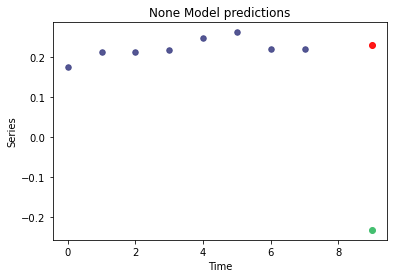

In [108]:
create_predictions_plot(model, X_val_test, y_val_test)

In [226]:
# Train on the entire set 
train_set = np.c_[train_set_time, train_set_time_val, train_set_time_test]
X, y = create_x_y_truncated(train_set, window_length)
X, y = shuffle_x_y(X, y)

In [168]:
# Using the best configuration and training it for 40 epochs
n_epochs = 40
model = build_convolutional_model(optimizer="nadam", dense_units=128, 
                                 n_dense_layers=1, n_stacks=2)
model.fit(X, y,
          validation_data = (X_val_test, y_val_test),
         epochs = n_epochs)

Epoch 1/40
147/147 [==============================] - 1s 4ms/step - loss: 0.6913 - val_loss: 1.5328
Epoch 2/40
147/147 [==============================] - 0s 3ms/step - loss: 0.5156 - val_loss: 1.4642
Epoch 3/40
147/147 [==============================] - 0s 3ms/step - loss: 0.4691 - val_loss: 1.5924
Epoch 4/40
147/147 [==============================] - 0s 3ms/step - loss: 0.4295 - val_loss: 1.2124
Epoch 5/40
147/147 [==============================] - 0s 3ms/step - loss: 0.4225 - val_loss: 1.1762
Epoch 6/40
147/147 [==============================] - 1s 4ms/step - loss: 0.4294 - val_loss: 1.3022
Epoch 7/40
147/147 [==============================] - 0s 3ms/step - loss: 0.4062 - val_loss: 1.1532
Epoch 8/40
147/147 [==============================] - 0s 3ms/step - loss: 0.4115 - val_loss: 1.2614
Epoch 9/40
147/147 [==============================] - 1s 5ms/step - loss: 0.4284 - val_loss: 1.2439
Epoch 10/40
147/147 [==============================] - 0s 3ms/step - loss: 0.4030 - val_loss: 1.3210

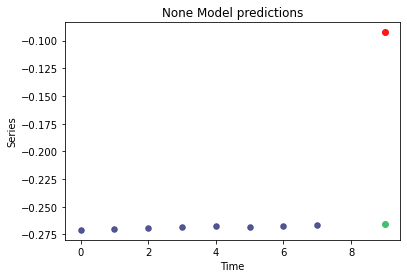

In [189]:
create_predictions_plot(model, X_val_test, y_val_test)

In [109]:
# Export this best model and then host it!!!!!
model.save("models/gdp_prediction_model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/gdp_prediction_model\assets


-------------------------------------------------------------------------------

### Remove Outliers and train the model

In [190]:
from sklearn.cluster import DBSCAN

In [227]:
dbs = DBSCAN(min_samples=2, eps=0.5)
dbs.fit(X.squeeze())

DBSCAN(min_samples=2)

In [232]:
X.squeeze().shape

(4680, 8)

In [233]:
non_outlier_mask = np.where(dbs.labels_ != -1)[0]

In [234]:
X = X[non_outlier_mask]
y = y[non_outlier_mask]

In [235]:
dbs.fit(X_val_test.squeeze())
X_val_test_mask = np.where(dbs.labels_ != 0)[0]
X_val_test = X_val_test[X_val_test_mask]
y_val_test = y_val_test[X_val_test_mask]

In [236]:
# Using the best configuration and training it for 40 epochs
n_epochs = 40
model = build_convolutional_model(optimizer="nadam", dense_units=128, 
                                 n_dense_layers=1, n_stacks=2)
model.fit(X, y,
          validation_data = (X_val_test, y_val_test),
         epochs = n_epochs)

Epoch 1/40
141/141 [==============================] - 1s 4ms/step - loss: 0.3057 - val_loss: 6.1189
Epoch 2/40
141/141 [==============================] - 1s 4ms/step - loss: 0.1988 - val_loss: 4.8606
Epoch 3/40
141/141 [==============================] - 0s 3ms/step - loss: 0.1953 - val_loss: 4.0342
Epoch 4/40
141/141 [==============================] - 0s 3ms/step - loss: 0.1966 - val_loss: 4.7568
Epoch 5/40
141/141 [==============================] - 0s 3ms/step - loss: 0.1920 - val_loss: 4.5653
Epoch 6/40
141/141 [==============================] - 0s 3ms/step - loss: 0.1958 - val_loss: 4.1985
Epoch 7/40
141/141 [==============================] - 0s 3ms/step - loss: 0.1910 - val_loss: 5.1187
Epoch 8/40
141/141 [==============================] - 0s 3ms/step - loss: 0.1907 - val_loss: 4.2604
Epoch 9/40
141/141 [==============================] - 0s 3ms/step - loss: 0.1929 - val_loss: 3.7405
Epoch 10/40
141/141 [==============================] - 0s 3ms/step - loss: 0.1935 - val_loss: 4.3738

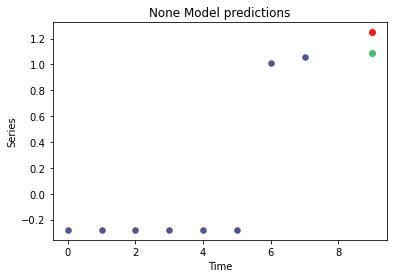

In [249]:
create_predictions_plot(model, X_val_test, y_val_test)

In [250]:
model.save("models/gdp_model_building_2")

INFO:tensorflow:Assets written to: models/gdp_model_building_2\assets
